# Capstone project: Heartbeat Sounds Classification
Classifying heartbeat anomalies from stethoscope audio
**Notebook 1: EDA**

# Problem Statement:
Stethoscope is good in detecting the first warning signs of heart disease. However, this is always done by frontline health workers, mostly when we are sick or during our annual physical examination. Although digital stethoscopes is available but we still need healthcare professional to determine whether an individual is having hearbeat irregularities or abnormalities and need for further check-up. 
It is well known that early detection and intervention in heart disease (or any disease) will greatly imporves the lifespan and the effectiveness of treatment options. 
The goal of this project is to use machine learning methods to identify and classify heartbeat sounds from audio collected from stethoscopes into normal versus various non-normal heartbeat sounds.

To achieve this, tasks are divided into **two Tasks**:
1. Identify the locations of heart sounds from the audio.
2. Classify the heart sounds into one of several categories (normal v. various non-normal heartbeat sounds -asthma, pneumonia and bronchiolitis).


### Target Audience:
1. Untrained frontline health workers to help determine whether an individual should bre reffered to expert diagnosis.
2. Consumer who can frequently check their respiratory health or constantly monitor if there is an heartbeat irregularities that prompt them to seek treatment in early stage. 

### Success Metric
Model selections: Decision Tree, Random Forest, SVM Classifier, RNN (recurrent neural network)
Evaluation metric: Accuracy score

### Data Source
[kaggle dataset: Heartbeat Sounds](https://www.kaggle.com/kinguistics/heartbeat-sounds)

### Potential Challenge
1. No experience in handling of unstructure audio data and its extra step for pre-processing, features extraction
2. Not the domain expert in respiratory health
3. Not sure the feasibility to complete both tasks within the time given.

## Importing Libraries

In [1]:
import librosa as lr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.signal import welch
from librosa import display
from glob import glob

import IPython.display as ipd  #audio playback
import wave                    # library handles the parsing of WAV file headers

#To visualize the whole grid
pd.options.display.max_columns = 999

#from keras.preprocessing.sequence import pad_sequences

%matplotlib inline
%pylab inline


Populating the interactive namespace from numpy and matplotlib


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['display']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Task 1: Heart Sound Segmentation

This task is to produce a method that can locate S1(lub) and S2(dub) sounds within audio data, segmenting the Normal audio files in both datasets.

Content of given datasets:
- The dataset is split into two sources, A and B:
- set_a.csv - Labels and metadata for heart beats collected from the general public via an **iPhone app**
- setatiming.csv - contains gold-standard timing information for the "normal" recordings from Set A.
- set_b.csv - Labels and metadata for heart beats collected from a clinical trial in hospitals using a **digital stethoscope**
- audio files - Varying lengths, between 1 second and 30 seconds. (some have been clipped to reduce excessive noise and provide the salient fragment of the sound).

source: [Peter Bentley et al](http://www.peterjbentley.com/heartchallenge/)

# 1 Data Cleaning and Exploratory Data Analysis (EDA)

## List all datasets downloaded for Task 1
- two sets of wav files (Atraining_normal, Btraining_normal)
- two csv files that compiled the list of wav files with portion of the S1 & S2 location

In [2]:
ls ../datasets/challenge1/

Atraining_normal/         Btraining_Normal/
Atraining_normal_seg.csv  Btraining_normal_seg.csv


In [3]:
ls ../datasets/challenge1/Atraining_normal/

201101070538.wav  201103101140.wav  201104141251.wav  201106210943.wav
201101151127.wav* 201103140132.wav  201105011626.wav  201106221418.wav
201102081152.wav* 201103140135.wav  201105021654.wav  201106221450.wav
201102081321.wav  201103140822.wav  201105021804.wav  201108011112.wav
201102201230.wav  201103151912.wav  201105151450.wav  201108011114.wav
201102260502.wav  201103170121.wav  201106111136.wav  201108011115.wav
201102270940.wav  201103221214.wav  201106141148.wav  201108011118.wav
201103090635.wav  201104122156.wav  201106151236.wav


## 1.1 EDA : csv file

In [4]:
## part of S1 and S2 sounds are given
## Task to to locate the S1 & S2 sounds of all the hearbeats in the unlabelled group:

df_atrain = pd.read_csv('../datasets/challenge1/Atraining_normal_seg.csv')
df_atrain.head()

,Unnamed: 0,S1,S2,S1.1,S2.1,S1.2,S2.2,S1.3,S2.3,S1.4,S2.4,S1.5,S2.5,S1.6,S2.6,S1.7,S2.7,S1.8,S2.8,S1.9,S2.9,S1.10,S2.10,S1.11,S2.11,S1.12,S2.12,S1.13,S2.13,S1.14,S2.14,S1.15,S2.15,S1.16,S2.16,S1.17,S2.17,S1.18,S2.18,Unnamed: 39
0,201102081321.aif,10021.0,20759,35075,47244,62992,73729,88761,101646,115246,127415,143163.0,153900.0,168216.0,180385.0,195417.0,206155.0,220471.0,231924.0,272010.0,283463.0,297779.0,309232.0,324264.0,335001.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,201102260502.aif,NaN,11526,27941,42197,58163,71278,88955,102641,122028,134573,152821.0,184753.0,197869.0,216686.0,230942.0,251211.0,265168.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,201103090635.aif,5366.0,17632,31432,44464,59030,71296,86629,99661,116527,128793,144125.0,156391.0,174024.0,185523.0,200856.0,213122.0,226154.0,239187.0,252220.0,265252.0,277518.0,290551.0,303583.0,315849.0,329649.0,342681.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,201103140132.aif,16358.0,29272,89539,105036,128282,142057,170469,183383,207490,221265,242789.0,256564.0,279810.0,292725.0,320275.0,334911.0,363323.0,377098.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,201103140822.aif,3444.0,18080,44770,58545,84374,98149,123977,134309,157555,175635,195437.0,214378.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df_btrain = pd.read_csv('../datasets/challenge1/Btraining_normal_seg.csv')
df_atrain.head()

,Unnamed: 0,S1,S2,S1.1,S2.1,S1.2,S2.2,S1.3,S2.3,S1.4,S2.4,S1.5,S2.5,S1.6,S2.6,S1.7,S2.7,S1.8,S2.8,S1.9,S2.9,S1.10,S2.10,S1.11,S2.11,S1.12,S2.12,S1.13,S2.13,S1.14,S2.14,S1.15,S2.15,S1.16,S2.16,S1.17,S2.17,S1.18,S2.18,Unnamed: 39
0,201102081321.aif,10021.0,20759,35075,47244,62992,73729,88761,101646,115246,127415,143163.0,153900.0,168216.0,180385.0,195417.0,206155.0,220471.0,231924.0,272010.0,283463.0,297779.0,309232.0,324264.0,335001.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,201102260502.aif,NaN,11526,27941,42197,58163,71278,88955,102641,122028,134573,152821.0,184753.0,197869.0,216686.0,230942.0,251211.0,265168.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,201103090635.aif,5366.0,17632,31432,44464,59030,71296,86629,99661,116527,128793,144125.0,156391.0,174024.0,185523.0,200856.0,213122.0,226154.0,239187.0,252220.0,265252.0,277518.0,290551.0,303583.0,315849.0,329649.0,342681.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,201103140132.aif,16358.0,29272,89539,105036,128282,142057,170469,183383,207490,221265,242789.0,256564.0,279810.0,292725.0,320275.0,334911.0,363323.0,377098.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,201103140822.aif,3444.0,18080,44770,58545,84374,98149,123977,134309,157555,175635,195437.0,214378.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
### In setA csv file, there are total of 21 rows 
### Rows: 21 wav files compiled with their S1 & S2 location (stored in column)
df_atrain.shape

(21, 40)

In [7]:
### In setB csv file, there are total of 90 wav files
df_btrain.shape

(90, 61)

### Atraining_normal_seg.csv file
- total of 21 rows
- S1, S2 in either float/int datatype
- Missing value observed starting from columns 11 (i.e. Sx.5) onwards (except 2 wav files have missing value on S1). These are due to the wav files are in different length. No values meant the wav files end.
- Most of the wav files are with at least 5 pairs of S1,S2 value. 

### Btraining_normal_seg.csv file
- total of 90 rows.
- Similar trend observed, but with only S2, S1.1, S1.2 columns have complete set of values. 

In [8]:
df_atrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 40 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   21 non-null     object 
 1   S1           19 non-null     float64
 2   S2           21 non-null     int64  
 3   S1.1         21 non-null     int64  
 4   S2.1         21 non-null     int64  
 5   S1.2         21 non-null     int64  
 6   S2.2         21 non-null     int64  
 7   S1.3         21 non-null     int64  
 8   S2.3         21 non-null     int64  
 9   S1.4         21 non-null     int64  
 10  S2.4         21 non-null     int64  
 11  S1.5         20 non-null     float64
 12  S2.5         20 non-null     float64
 13  S1.6         17 non-null     float64
 14  S2.6         17 non-null     float64
 15  S1.7         14 non-null     float64
 16  S2.7         14 non-null     float64
 17  S1.8         12 non-null     float64
 18  S2.8         11 non-null     float64
 19  S1.9      

In [9]:
df_btrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 61 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  90 non-null     object 
 1   S1          81 non-null     float64
 2   S2          90 non-null     int64  
 3   S1.1        90 non-null     int64  
 4   S2.1        90 non-null     int64  
 5   S1.2        85 non-null     float64
 6   S2.2        81 non-null     float64
 7   S1.3        77 non-null     float64
 8   S2.3        76 non-null     float64
 9   S1.4        64 non-null     float64
 10  S2.4        62 non-null     float64
 11  S1.5        53 non-null     float64
 12  S2.5        53 non-null     float64
 13  S1.6        46 non-null     float64
 14  S2.6        42 non-null     float64
 15  S1.7        38 non-null     float64
 16  S2.7        36 non-null     float64
 17  S1.8        34 non-null     float64
 18  S2.8        32 non-null     float64
 19  S1.9        29 non-null     flo

In [10]:
### Rename the Unnamed:0 column to wav_file
df_atrain.rename(columns = {'Unnamed: 0': 'wav_name'}, inplace = True)
df_btrain.rename(columns = {'Unnamed: 0': 'wav_name'}, inplace = True)

In [11]:
### Drop the last of df_atrain, which is not storing any S1 & S2 pair
df_atrain.drop(columns = ['Unnamed: 39'], inplace = True)
df_atrain.head()

,wav_name,S1,S2,S1.1,S2.1,S1.2,S2.2,S1.3,S2.3,S1.4,S2.4,S1.5,S2.5,S1.6,S2.6,S1.7,S2.7,S1.8,S2.8,S1.9,S2.9,S1.10,S2.10,S1.11,S2.11,S1.12,S2.12,S1.13,S2.13,S1.14,S2.14,S1.15,S2.15,S1.16,S2.16,S1.17,S2.17,S1.18,S2.18
0,201102081321.aif,10021.0,20759,35075,47244,62992,73729,88761,101646,115246,127415,143163.0,153900.0,168216.0,180385.0,195417.0,206155.0,220471.0,231924.0,272010.0,283463.0,297779.0,309232.0,324264.0,335001.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,201102260502.aif,NaN,11526,27941,42197,58163,71278,88955,102641,122028,134573,152821.0,184753.0,197869.0,216686.0,230942.0,251211.0,265168.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,201103090635.aif,5366.0,17632,31432,44464,59030,71296,86629,99661,116527,128793,144125.0,156391.0,174024.0,185523.0,200856.0,213122.0,226154.0,239187.0,252220.0,265252.0,277518.0,290551.0,303583.0,315849.0,329649.0,342681.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,201103140132.aif,16358.0,29272,89539,105036,128282,142057,170469,183383,207490,221265,242789.0,256564.0,279810.0,292725.0,320275.0,334911.0,363323.0,377098.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,201103140822.aif,3444.0,18080,44770,58545,84374,98149,123977,134309,157555,175635,195437.0,214378.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 1.2 EDA - Audio files


### Compile list of audio wav files in Atraining & Btraining folders

The **glob module** finds all the pathnames matching a specified pattern according to the rules used by the 
Unix shell, although results are returned in arbitrary order. 

use `glob()` to return a list of audio wav files that match the wav files' name in folder that store them.

In [12]:
### Atraining_normal folder
wav_dir_atrain = '../datasets/challenge1/Atraining_normal/'
atrain_wav = glob(wav_dir_atrain + '/*.wav')
print(f'Total wav file in Atraining_normal folder :{len(atrain_wav)}')

Total wav file in Atraining_normal folder :31


In [13]:
### Btraining_normal folder:
wav_dir_btrain = '../datasets/challenge1/Btraining_Normal/'
btrain_wav = glob(wav_dir_btrain + '/*.wav')
print(f'Total wav file in Btraining_normal folder :{len(btrain_wav)}')

Total wav file in Btraining_normal folder :200


### Getting basic information on the audio wav files

In both Atraining and Btraining folders, all of the heartbeat sounds are normal heartbeat and stored as **WAV** files.

In general, uncompressed audio is stored as a sequence of numbers that indicate the amplitude of the recorded sound pressure at each time point. In the WAV standard, these numbers are packed into a bytestring. The interpretation of this bytestring depends primarily on two factors: 
1. Sampling rate (framerate), usually given in Hertz, which indicates how many number samples comprise in one second's worth of data. 
2. Bit depth (sample width), number of bytes per sample.

On top of the two listed above, WAV file parameters include number of channels. Typically, they have 1 (mono) or 2 (for stereo). The data of a WAV file is given as a sequence of frames. A frame consists of samples. There is one sample per channel, per frame. Every wav file has a sample width, or, the number of bytes per sample. Typically this is either 1 or 2 bytes.

The `wave` library handles the parsing of WAV file headers, which include the parameters mentioned above. 

**Atraining**
- mono channel
- sample width = 2 bytes (16 bits per sample)
- sampling rate = 44.1kHz

**Btraining**
- mono channel
- sample width = 2 bytes (16 bits per sample)
- sampling rate = 4kHz

In [14]:
### Atraining
f = wave.open(atrain_wav[0])
f.getparams()

_wave_params(nchannels=1, sampwidth=2, framerate=44100, nframes=347886, comptype='NONE', compname='not compressed')

In [15]:
### Btraining
f = wave.open(btrain_wav[0])
f.getparams()

_wave_params(nchannels=1, sampwidth=2, framerate=4000, nframes=6497, comptype='NONE', compname='not compressed')

### 1.2.1 Defining plot function for visualization of audio wav file in time and frequency domain

**LibROSA** is used in this EDA. Librosa is a python package for music and audio analysis. It provides the building blocks necessary to create music information retrieval systems.

`librosa.load()` function returns 2 things:
- numpy array of amplitudes
- sampling rate (if keep the argument sr = None, it will load the audio file in its original sampling rate, else it will use its default sampling rate of 22050)
(default sampling rate = 22050Hz. if set sr = None, it will return the original sampling rate of the audio wav).


In [16]:
### Define function to plot the audio in time domain
### This function return: 1) audio_data in array, 2) sampling rate, 
### 3) duration of audio wav, 4) plot the audio data in time domain

def time_plot(audio):
    
    #Load audio with librosa
    data, sfreq = lr.load(audio)
    
    plt.figure(figsize = (10,6))
    lr.display.waveplot(data, sr = sfreq);
    
    plt.xlabel('Time, s', fontsize=14)
    plt.ylabel('Amplitude', fontsize =14)
    plt.title(audio[40:], fontsize =18)
    
    audio_data = data
    sampling_frequency = sfreq
    dur = lr.get_duration(data)
    return audio_data, sampling_frequency, dur

In [17]:
### Define function to plot the audio in frequency domain

def fft_plot(audio):
    
    #Load audio with librosa
    data, sfreq = lr.load(audio)
    
    #check if the len of audio data is odd number
    n = len(data)
    if n%2 !=0:
        n = n+1   # if size of audio data is in odd number, add one to it before proceed
   
    t = 1/sfreq
    yf = scipy.fft(data)
    xf = np.linspace(0.0, 1.0/(2.0*t), n//2)    #frequency
    
    fig, ax = plt.subplots(figsize = (8,6))
    ax.plot(xf, 2.0/n * np.abs(yf[:n//2]))
    plt.grid()
    plt.xlabel('Frequency, Hz', fontsize = 14)
    plt.ylabel('Amplitude', fontsize =14)
    plt.title(audio[40:], fontsize =18)

    ax.set_xscale('log')    #set frequency axis in log scale
    ax.set_xlim(1, 10000)
    ax.set_ylim(0, 0.04)
    
    return plt.show()
    

In [19]:
### Define function to plot the PSD (Power Spectra Density)
def psd_plot(audio):
    
    #Load audio with librosa
    data, sfreq = lr.load(audio)
    freq, psd = welch(data, fs = sfreq)
    
    fig, ax = plt.subplots(figsize = (8, 6))
    ax.plot(freq, psd, linestyle = '-', color = 'blue')
    
    ax.set_xlabel('Frequency, Hz', fontsize =14)
    ax.set_ylabel('PSD [V**2 / Hz', fontsize =14)
    ax.set_title(audio[40:], fontsize =18)
    
    ax.set_xlim(0, 2000)


### 1.2.2 EDA on audio from Atraining folder

**Normal Category of heartbeat**
In the Normal category there are normal, healthy heart sounds. These may contain noise in the final second of the recording as the device is removed from the body. They may contain a variety of background noises (from traffic to radios). They may also contain occasional random noise corresponding to breathing, or brushing the microphone against clothing or skin. A normal heart sound has a clear “lub dub, lub dub” pattern, with the time from “lub” to “dub” shorter than the time from “dub” to the next “lub” (when the heart rate is less than 140 beats per minute). Note the temporal description of “lub” and “dub” locations over time in the following illustration:

…lub……….dub……………. lub……….dub……………. lub……….dub……………. lub……….dub…

In medicine we call the **lub** sound "**S1**" and the **dub** sound "**S2**". Most normal heart rates at rest will be between about 60 and 100 beats (‘lub dub’s) per minute. However, note that since the data may have been collected from children or adults in calm or excited states, the heart rates in the data may vary from 40 to 140 beats or higher per minute. Dataset B also contains noisy_normal data - normal data which includes a substantial amount of background noise or distortion. 

Duration of audio wav file: 7.89 sec


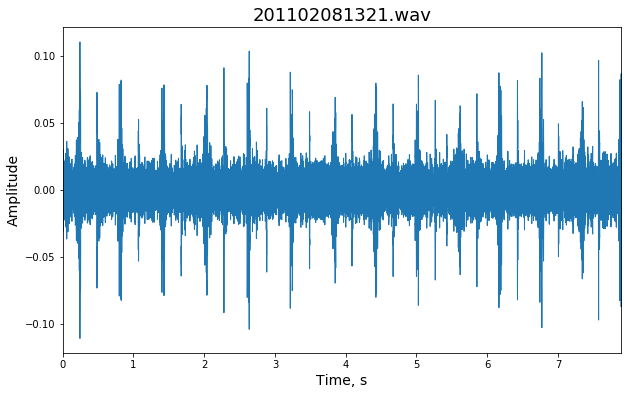

In [20]:
### Plot audio from atrain_wav[0]
data, sfreq, dur = time_plot(atrain_wav[0])

#print(f'Length of audio wav file: {round(wav_duration, 2)} sec')
print(f'Duration of audio wav file: {round(dur, 2)} sec')

In [21]:
### Listen to the audio from atrain_wav[0]
ipd.Audio(atrain_wav[0])

The heart beat audio is almost mask by the background noise.
Visual inpection on the audio in frequency domain (Frequency Spectrum)

The frequency spectrum shown in below graph observed that:
- the heart beat is at around 100Hz (small spike in the graph below).
- the amplitude of the heart beat is similar to the level of background noise. Thus, the audio is having poor SNR(signal to noise ratio). It agrees with the playback audio in above cell.


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Using scipy.fft as a function is deprecated and will be removed in SciPy 1.5.0, use scipy.fft.fft instead.
  


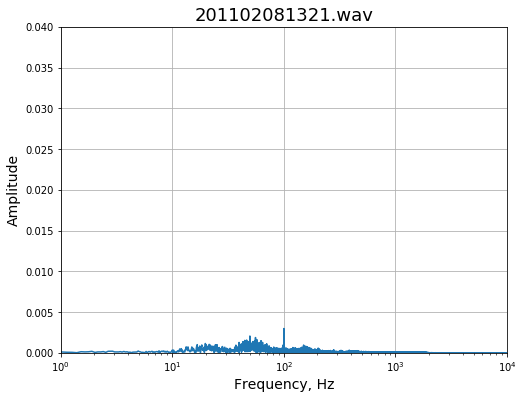

In [22]:
fft_plot(atrain_wav[0])

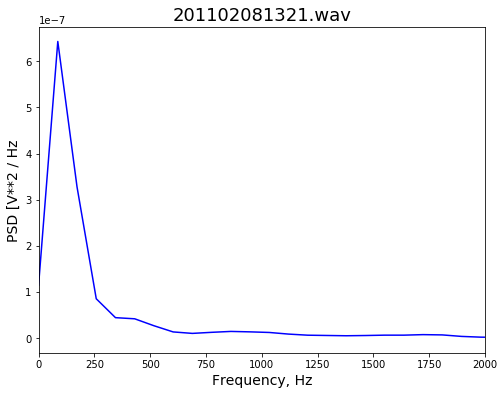

In [23]:
psd_plot(atrain_wav[0])

### 1.2.3 EDA on audio from Btraining folder

Contrary to the first audio file extracted from atrain, the first audio file extracted from btrain is having much better SNR (listen to the audio clip in the next few cells)

However, it is relatively short audio (only 2.05 sec compared to 7.89sec).

Duration of audio wav file: 2.05 sec


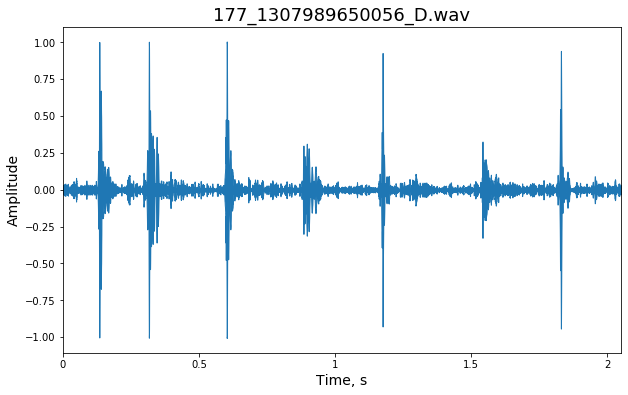

In [24]:
### Plot audio from btrain_wav[1]
data, sfreq, dur = time_plot(btrain_wav[1])

print(f'Duration of audio wav file: {round(dur, 2)} sec')

In [25]:
ipd.Audio(btrain_wav[1])
#ipd.Audio('../datasets/challenge1/Btraining_normal/230_1308595300880_B.wav')

The heart beat audio is clearly heard.

The frequency spectrum shown in below graph observed that:
- the heart beat is at around 100Hz (small spike in the graph below).
- the amplitude of this heart beat audio (0.02) is relatively higher than the previous audio wav (0.0025).
- though the SNR is better in this audio wav file, but a substantial amount of background noise exist as well.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Using scipy.fft as a function is deprecated and will be removed in SciPy 1.5.0, use scipy.fft.fft instead.
  


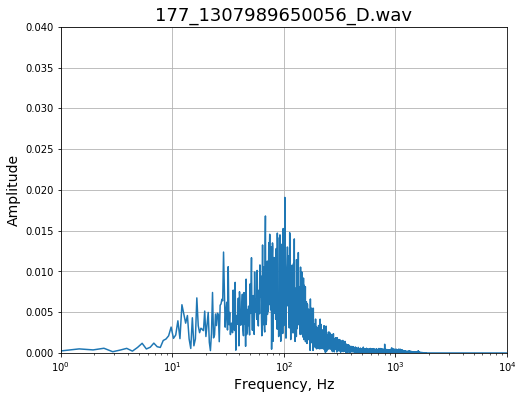

In [26]:
fft_plot(btrain_wav[1])

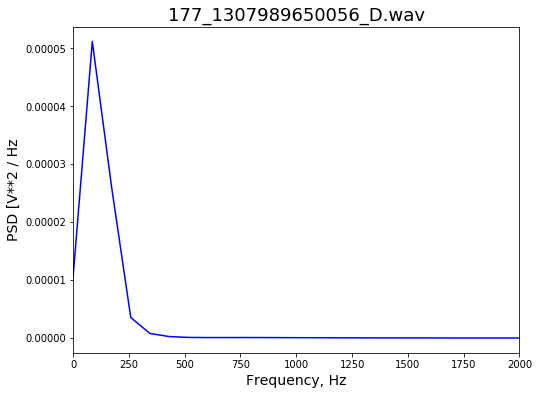

In [27]:
psd_plot(btrain_wav[1])

# 2.0 Pre-processing

The original recorded wav files in both set A and set B have certain level of contatimnation with background noise. This is observed especially in the frequency domain spectrum in EDA. Thus, we'll need to clean the wav file to only contain as much of the wanted audio signal (i.e. the S1 & S2 heartbeat sound) before modeling.

## 2.1 Down-sampling

In EDA, the hearbeat sound is around 100Hz. Though I have yet to explore the abnormal heartbeat sound, which is the 2nd challenge task, it should not exceed 1kHz.
Thus, decided to down-sample the heartbeat sound to **2kHz** according to the Nyquist Sampling Theorem.

In [28]:
### down-sampling atrain audio data to 2kHz sampling rate, store in y_atrain
y_atrain = []
sfreq = 2000

for i in range(len(atrain_wav)):
    y = lr.load(atrain_wav[i], sr = sfreq)
    y_atrain.append(list(y))

len(y_atrain)

31

In [29]:
### down-sampling btrain audio data to 2kHz sampling rate, store in y_btrain
y_btrain = []
sfreq = 2000

for i in range(len(btrain_wav)):
    y = lr.load(btrain_wav[i], sr = sfreq)
    y_btrain.append(list(y))

len(y_btrain)

200

## 2.2 Denoised audio signal

From EDA, we can hear that the recorded audio is masked with background noise. Thigh could make it hard to detect the S1 and S2 signal.

stop-band energy (SBE) minimized dyadic orthogonal filter bank

**Wavelet Decomposition** (WD)

WD is a mathematical technology used to analyze signals by decomposition into various frequencies. WD is employed to process an original series into a group of sub-series. The advantage of the wavelet method is its' ability to highlight non-stationary processes and locate disturbances in time and frequency scale.

source: [A note on a practical relationship between filter coefficients and scaling and wavelet functions of Discrete Wavelet Transforms](https://www.sciencedirect.com/science/article/pii/S0893965911000905)

[Guide using wavelet transformation in machine learning](http://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/)

[Machine learning with signal processing techniques](http://ataspinar.com/2018/04/04/machine-learning-with-signal-processing-techniques/)

[pywavelets](https://pywavelets.readthedocs.io/en/latest/)

## 3.0 Sound Feature: MFCC

Mel Frequency Cepstral Coefficient (MFCC) is by far the most successful feature used in the field of Speech Processing. Speech is a non-stationary signal. As such, normal signal processing techniques cannot be directly applied to it.

Mel-frequency cepstral coefficients (MFCCs) are coefficients that collectively make up an MFC. They are derived from a type of cepstral representation of the audio clip (a nonlinear "spectrum-of-a-spectrum"). The difference between the cepstrum and the mel-frequency cepstrum is that in the MFC, the frequency bands are equally spaced on the mel scale, which approximates the human auditory system's response more closely than the linearly-spaced frequency bands used in the normal cepstrum. This frequency warping can allow for better representation of sound, for example, in audio compression.

MFCCs are commonly derived as follows: -Take the Fourier transform of (a windowed excerpt of) a signal. -Map the powers of the spectrum obtained above onto the mel scale, using triangular overlapping windows. -Take the logs of the powers at each of the mel frequencies. -Take the discrete cosine transform of the list of mel log powers, as if it were a signal. The MFCCs are the amplitudes of the resulting spectrum.

In general, a 39-dimensional feature vector is used which is composed of first 13 MFCCs and their corresponding 13 delta and 13 delta-delta.


source: [Heart sounds analysis and classification with LSTM](https://www.kaggle.com/mychen76/heart-sounds-analysis-and-classification-with-lstm)

In [30]:
def extract(self, x, sample_rate):
        """Transform the given signal into a logmel feature vector.

        Args:
            x (np.ndarray): Input time-series signal.
            sample_rate (number): Sampling rate of signal.

        Returns:
            np.ndarray: The logmel feature vector.
        """
        # Resample to target sampling rate
        x = librosa.resample(x, sample_rate, self.sample_rate)

        # Compute short-time Fourier transform
        D = librosa.stft(x, n_fft=self.n_window, hop_length=self.hop_length)
        # Transform to Mel frequency scale
        S = np.dot(self.mel_fb, np.abs(D)).T
        # Apply log nonlinearity and return as float32
        return librosa.amplitude_to_db(S, ref=np.max, top_db=None) 

In [31]:
# Here's a sample generate mfccs from a wave file (use: btrain_wav[1])
y, sr = lr.load(btrain_wav[1])
mfccs = lr.feature.mfcc(y = y, sr = sr)
print(mfccs)
print(mfccs.shape)

[[-375.3889    -378.74017   -385.5337    ... -401.5937    -401.86694
  -388.06757  ]
 [ 178.60843    183.53963    179.9034    ...  169.25018    166.991
   160.60495  ]
 [  34.871284    45.667755    50.551086  ...   62.08348     58.979454
    35.158813 ]
 ...
 [  -5.7997413   -2.3617916    3.841741  ...   -1.9819771    3.480716
     4.928215 ]
 [  -3.1636555   -1.3876331    3.59822   ...    4.850338     7.5443563
     3.9274077]
 [  -0.788268    -1.7108359   -2.5575104 ...    2.7911658    4.874068
     1.7226297]]
(20, 89)


In [32]:
# Use a pre-computed log-power Mel spectrogram
S = lr.feature.melspectrogram(y = y, sr = sr, n_mels = 128, fmax = 8000)
log_S = lr.feature.mfcc(S = lr.power_to_db(S))
print(log_S)
print(log_S.shape)

[[-3.5849930e+02 -3.6211340e+02 -3.6958542e+02 ... -3.8750253e+02
  -3.8757840e+02 -3.7184494e+02]
 [ 1.8086169e+02  1.8868661e+02  1.8605734e+02 ...  1.7701086e+02
   1.7413503e+02  1.6189035e+02]
 [ 1.4085028e+01  2.4524153e+01  3.0740719e+01 ...  4.8042648e+01
   4.4856049e+01  2.2355785e+01]
 ...
 [-1.8885291e+00 -1.7007257e+00 -1.3978953e+00 ...  4.2634506e+00
   6.3681583e+00  1.9858363e+00]
 [-2.3291305e-01 -1.1706544e+00 -6.0632372e+00 ... -1.7707628e+00
   2.1376648e+00  2.0223789e+00]
 [ 2.6002103e-01  2.3345690e+00 -4.9656636e-01 ... -1.4610364e+00
   9.3258005e-01  4.8905149e+00]]
(20, 89)


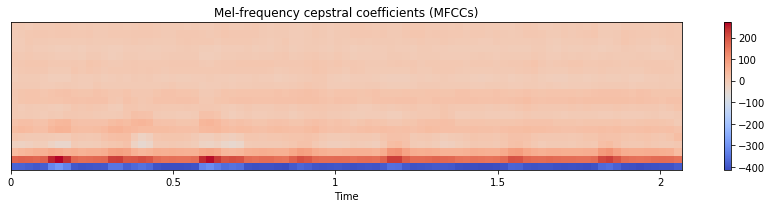

In [25]:
# Visualize the MFCC series
# Mel-frequency cepstral coefficients (MFCCs)
plt.figure(figsize = (12,3))
lr.display.specshow(mfccs, x_axis = 'time')
plt.colorbar()
plt.title('Mel-frequency cepstral coefficients (MFCCs)')
plt.tight_layout()

**onset detector**

Basic onset detector. Locate note onset events by picking peaks in an onset strength envelope. The peak_pick parameters were chosen by large-scale hyper-parameter optimization over the dataset provided

In [33]:
# Get onset times from a signal
onset_frames = lr.onset.onset_detect(y = y, sr = sr)
lr.frames_to_time(onset_frames, sr = sr)

array([0.16253968, 0.34829932, 0.41795918, 0.62693878, 0.90557823,
       1.20743764, 1.57895692, 1.85759637])

In [34]:
# use a pre-computed onset envelope
o_env = lr.onset.onset_strength(y, sr = sr)
times = lr.frames_to_time(np.arange(len(o_env)), sr=sr)
onset_frames = lr.onset.onset_detect(onset_envelope=o_env, sr = sr)

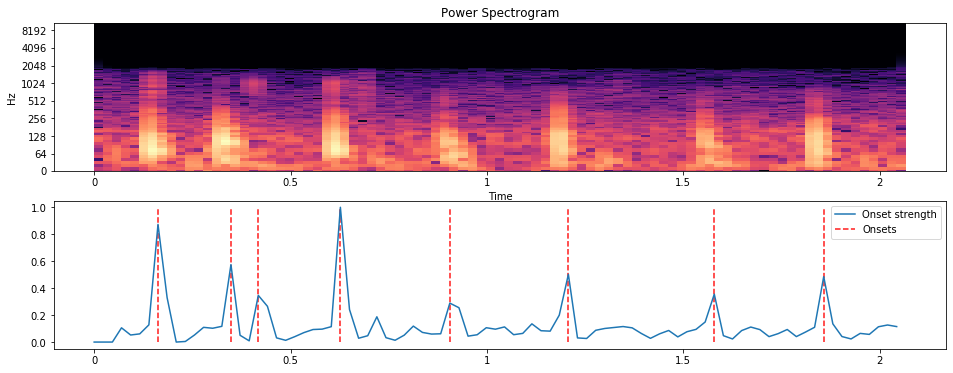

In [28]:
# Visualize it

D = np.abs(lr.stft(y))    
#The STFT represents a signal in the time-frequency domain by computing discrete Fourier transforms (DFT)
#over short overlapping windows.
plt.figure(figsize = (16,6))
ax1 = plt.subplot(2,1,1)
lr.display.specshow(lr.amplitude_to_db(D, ref = np.max), x_axis = 'time', y_axis = 'log')
#plt.colorbar()
plt.title('Power Spectrogram')


plt.subplot(2,1,2, sharex = ax1)
plt.plot(times, o_env, label = 'Onset strength')
plt.vlines(times[onset_frames], 0, o_env.max(), color = 'r', alpha = 0.9, linestyle = '--', label = 'Onsets')

plt.axis('tight')
plt.legend(frameon = True, framealpha = 0.75)


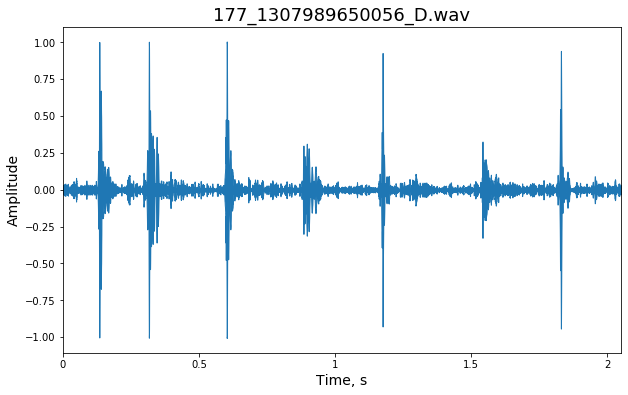

In [88]:
data, sfreq, dur = time_plot(btrain_wav[1])

In [20]:
df_btrain[df_btrain['wav_name'] == '177_1307989650056_D.aiff']

,wav_name,S1,S2,S1.1,S2.1,S1.2,S2.2,S1.3,S2.3,S1.4,S2.4,S1.5,S2.5,S1.6,S2.6,S1.7,S2.7,S1.8,S2.8,S1.9,S2.9,S1.10,S2.10,S1.11,S2.11,S1.12,S2.12,S1.13,S2.13,S1.14,S2.14,S1.15,S2.15,S1.16,S2.16,S1.17,S2.17,S1.18,S2.18,S1.19,S2.19,S1.20,S2.20,S1.21,S2.21,S1.22,S2.22,S1.23,S2.23,S1.24,S2.24,S1.25,S2.25,S1.26,S2.26,S1.27,S2.27,S1.28,S2.28,S1.29,S2.29
75,177_1307989650056_D.aiff,1263.0,2401,3610,4678,6154.0,7292.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
### S1,S2 location in time domain recording in the given csv file:
df_btrain.iloc[75,1:6]/4000   #divided by 4kHz sampling rate to find the tn

S1      0.31575
S2      0.60025
S1.1     0.9025
S2.1     1.1695
S1.2     1.5385
Name: 75, dtype: object